In [1]:
!pip install pandas seaborn scikit-image opencv-python scikit-learn tensorflow pydot keras

  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_image-0.23.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached tensorflow-2.16.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached pydot-2.0.0-py3-none-any.whl.metadata (9.6 kB)
  Using cached keras-3.2.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.

In [39]:
import numpy as np
import pandas as pd

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from PIL import Image
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
train_directory = 'data/test/'
class_names=os.listdir(train_directory)
print(class_names)

['pneumonia', 'normal']


In [4]:
input_path = 'data/'

In [5]:
for _set in ['train', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/normal'))
    n_infect = len(os.listdir(input_path + _set + '/pneumonia'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1342, pneumonia images: 3876
Set: test, Normal images: 234, pneumonia images: 390


In [6]:
# Re-sizing the images
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32

In [7]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [8]:
train = Image_gen.flow_from_directory('data/train',
                                       batch_size=32,
                                       class_mode='binary',
                                       target_size=(224,224)
                                       )

validation = Image_gen.flow_from_directory('data/val',
                                              batch_size=2,
                                              class_mode='binary',
                                              target_size=(224,224)
                                            )

test = val_Datagen.flow_from_directory('data/test',
                                       batch_size=2,
                                       class_mode='binary',
                                       target_size=(224,224)
                                      )

Found 5217 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
img, label = next(train)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [11]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

In [12]:
# Calculate class weights
weight_for_class_normal = 5291 / (1341 * 2)
weight_for_class_pneumonia = 5291 / (3875 * 2)

class_weights = {0: weight_for_class_normal, 1: weight_for_class_pneumonia}


In [13]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in resnet_model.layers:
        layer.trainable = False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    res_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])
    return res_model

In [14]:
res_model = create_model()

2024-04-14 05:17:44.459457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 05:17:44.518673: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
res_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [16]:
history = res_model.fit(train,
                        epochs=10, 
                        validation_data=validation,
                        steps_per_epoch=100,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=8)],
                        class_weight=class_weights,  # Include class weights here
                        batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7939 - loss: 0.4161 - precision: 0.9180 - val_accuracy: 0.8125 - val_loss: 0.5777 - val_precision: 0.7273 - learning_rate: 0.0010
Epoch 2/10
 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.8978 - loss: 0.2615 - precision: 0.9700

2024-04-14 05:23:20.227309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8950 - loss: 0.2660 - precision: 0.9680 - val_accuracy: 0.9375 - val_loss: 0.2470 - val_precision: 0.8889 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8873 - loss: 0.2543 - precision: 0.9661 - val_accuracy: 0.8750 - val_loss: 0.2685 - val_precision: 0.8000 - learning_rate: 0.0010
Epoch 4/10
 64/100 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9035 - loss: 0.2150 - precision: 0.9740

2024-04-14 05:28:05.325675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9049 - loss: 0.2146 - precision: 0.9735 - val_accuracy: 0.6250 - val_loss: 0.5053 - val_precision: 0.5833 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9150 - loss: 0.2147 - precision: 0.9710 - val_accuracy: 0.6875 - val_loss: 0.7314 - val_precision: 0.6364 - learning_rate: 0.0010
Epoch 6/10
 64/100 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9151 - loss: 0.2102 - precision: 0.9749

2024-04-14 05:32:32.141898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9139 - loss: 0.2159 - precision: 0.9735 - val_accuracy: 0.8750 - val_loss: 0.4769 - val_precision: 0.8000 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.8953 - loss: 0.2300 - precision: 0.9718 - val_accuracy: 0.6875 - val_loss: 0.6399 - val_precision: 0.6154 - learning_rate: 0.0010
Epoch 8/10
 64/100 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9155 - loss: 0.2135 - precision: 0.9735 

2024-04-14 05:38:03.025996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9138 - loss: 0.2145 - precision: 0.9725 - val_accuracy: 0.9375 - val_loss: 0.1909 - val_precision: 1.0000 - learning_rate: 0.0010
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9002 - loss: 0.2249 - precision: 0.9690 - val_accuracy: 0.7500 - val_loss: 0.5415 - val_precision: 0.7000 - learning_rate: 0.0010
Epoch 10/10
 64/100 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9068 - loss: 0.2159 - precision: 0.9729

2024-04-14 05:42:39.040118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9094 - loss: 0.2128 - precision: 0.9731 - val_accuracy: 0.9375 - val_loss: 0.2773 - val_precision: 0.8889 - learning_rate: 0.0010


Text(0, 0.5, 'Loss')

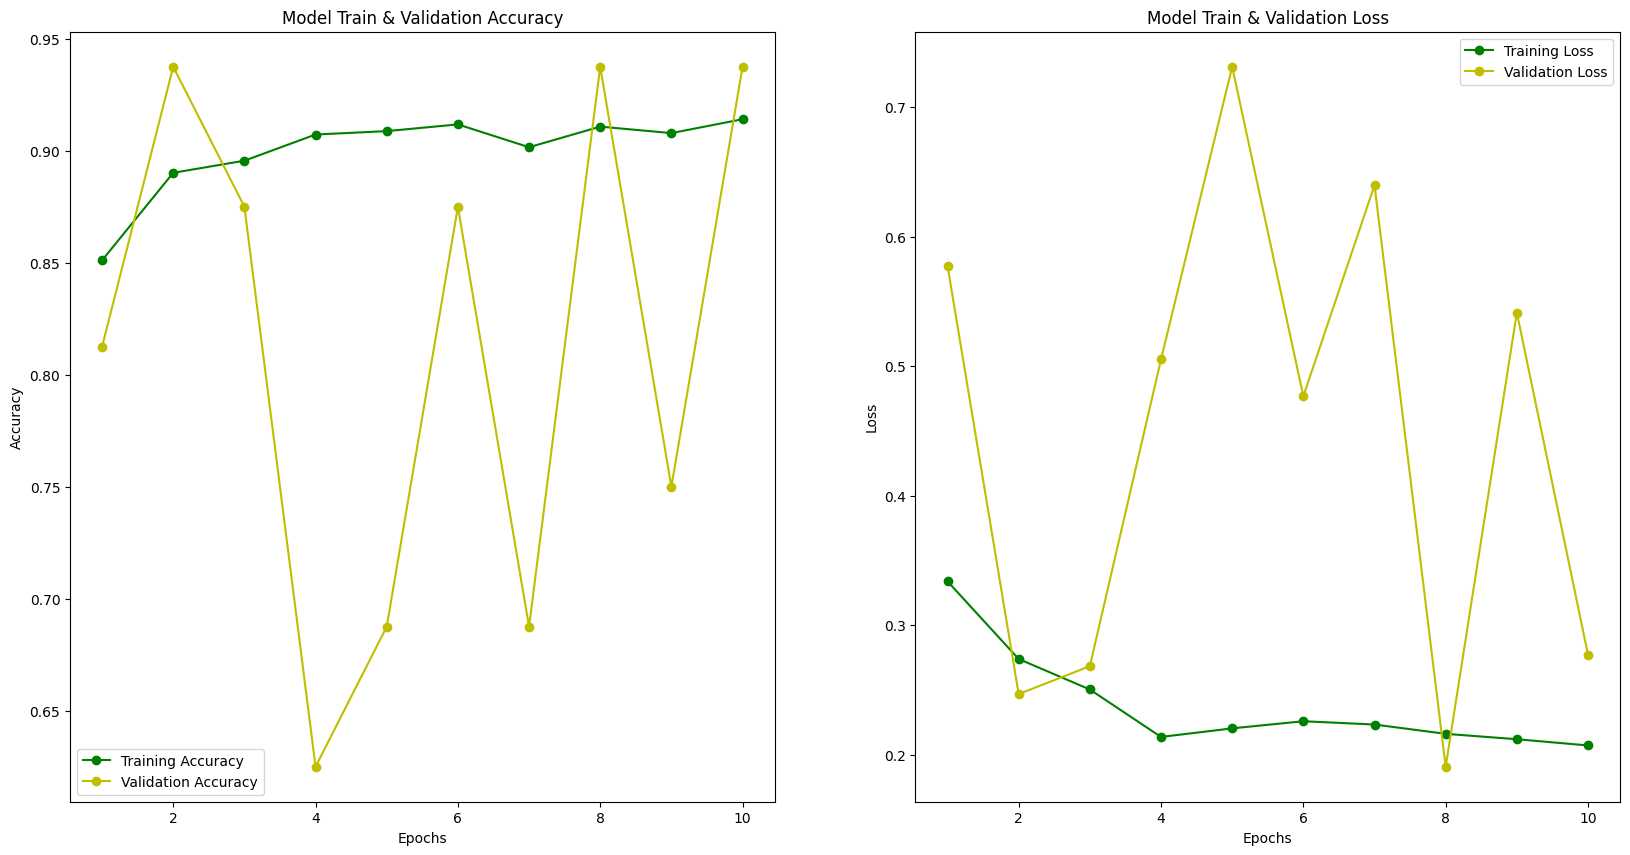

In [17]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

In [21]:
# Evaluating the model on train and test
score = res_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

164/164 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.9252 - loss: 0.1823 - precision: 0.9801
Train Loss:  0.18389461934566498
Train Accuracy:  0.9242860078811646
312/312 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8967 - loss: 0.2735 - precision: 0.9417

Test loss:  0.24545300006866455
Test Accuracy:  0.9054487347602844


In [ ]:
# from tensorflow.keras.models import load_model

# model_path = 'paths/resnet_1.keras'
# res_model = load_model(model_path)

In [38]:
predictions = res_model.predict(test)
predictions = (predictions > 0.5).astype(int) 

# True labels
true_labels = test.classes

# Calculate precision and F1 score
precision = precision_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Precision: 0.9004
F1 Score: 0.9042307692307693


In [23]:
# After training
res_model.save('paths/restnet_2.h5')

In [24]:
res_model.save('paths/resnet_2.keras')